In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

from utils import normsq, single_rbf, pairwise_distances

# SVGD

## Update
Let's define the update rule.

In [2]:
def phi_j(x, y, logp, kernel):
    """
    IN: 
    x and y are arrays of length d
    kernel is a callable that computes the kernel k(x, y, kernel_params)
    logp is the log of a differentiable pdf p
    
    OUT: 
    \nabla_x log(p(x)) * k(x, y) + \nabla_x k(x, y)
    
    that is, phi(x_i) = \sum_j phi_j(x_j, x_i)
    """
    assert x.ndim == 1 and y.ndim == 1
    return grad(logp)(x) * kernel(x, y) + grad(kernel)(x, y)

phi_j_batched = vmap(phi_j, (0, 0, None, None), 0)

def update(x, logp, stepsize, kernel_params):
    """
    IN:
    x is an np array of shape n x d
    logp is the log of a differentiable pdf p
    stepsize is a float
    kernel_params are a set of parameters for the kernel
    
    OUT:
    xnew = x + stepsize * \phi^*(x)
    that is, xnew is an array of shape n x d. The entries of x are the updated particles.
    
    note that this is an inefficient way to do things, since we're computing k(x, y) twice for each x, y combination.
    """
    assert x.ndim == 2
    kernel = lambda x, y: single_rbf(x, y, kernel_params)
    kerneltest = lambda x, y: np.exp(- normsq(x - y) / (2 * kernel_params ** 2))
#     assert kerneltest(x[0], x[1]) == kernel(x[0], x[1])
    
    xnew = []
    n = x.shape[0]
    for i, xi in enumerate(x):
        repeated = np.tile(xi, (n, 1))
        xnew.append(stepsize * np.sum(phi_j_batched(x, repeated, logp, kernel), axis = 0))
    xnew = np.array(xnew)
    xnew += x

    return xnew

# update = jit(update, static_argnums=(1,)) # logp is static

To accelerate the function `update` with `jit` we had to use the `static_argnums` argument. This is because `jit` only knows how to deal with functions that are 1) pure, that is no side effects, and 2) take only np arrays as inputs and outputs.

In effect, the `static_argnums` argument tells `jit` to ignore the callable input `logp`. Everytime it changes, `jit` recompiles.

## SVGD

In [4]:
def svgd(x, logp, stepsize, kernel_params, L, update_kernel_params=False, kernel_param_update_rule=None):
    """
    x is an np array of shape n x d
    logp is the log of a differentiable pdf p (callable)
    stepsize is a float
    kernel is a differentiable function k(x, y, h) that computes the rbf kernel (callable)
    L is an integer (number of iterations)
    
    if update_kernel_params is True, then kernel_param_update_rule must be given.
    kernel_param_update_rule is a callable that takes xnew as input and outputs an updated set of kernel parameters.
    
    OUT:
    Updated particles x (np array of shape n x d) after L steps of SVGD
    """
    assert x.ndim == 2

    for i in range(L):
        x = update(x, logp, stepsize, kernel_params)
        
        if np.any(np.isnan(x)):
            raise ValueError(f"NaN produced at iteration {i}")
        if update_kernel_params:
            kernel_params = kernel_param_update_rule(x)
#             print(f"iteration {i}, h: ", kernel_params)
#             print(f"iteration {i}, mean(x) = ", np.mean(x))
        
    return x

# Sample
## Experiment 1: one-dim Gaussian mixture

In [5]:
from jax.scipy.stats import multivariate_normal

### Experiment 2.1
Target distribution:
$$ p(x) = \mathcal N(x; 0, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(x; -10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

In [6]:
def kernel_param_update_rule(x):
    assert x.ndim == 2
    n = x.shape[0]
    
    h = np.median(pairwise_distances(x))**2 / np.log(n)
    return h

def p(x):
    """x is an np.array of shape (d,)"""
    assert x.ndim == 1 # doesn't work otherwise
    d = x.shape[0]
    return multivariate_normal.pdf(x, mean=np.zeros(d), cov=np.identity(d))

@jit
def logp(x):
    return np.log(p(x))

# works with:
n = 20
d = 1
stepsize = 0.1
L = 10

# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d))
x0 = x0 - 10 # sampled from q_0
x = x0
h = kernel_param_update_rule(x)
# print("initial h: ", h)
# print("initial mean: ", np.mean(x))

xout = svgd(x, logp, stepsize, h, L, update_kernel_params=True, kernel_param_update_rule=kernel_param_update_rule)
print(xout.shape)
xout

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(20, 1)


DeviceArray([[-0.6061736 ],
             [ 0.7066619 ],
             [ 0.8802205 ],
             [ 0.96482325],
             [-1.2316256 ],
             [-2.6203465 ],
             [ 0.08152342],
             [ 0.3646504 ],
             [-0.08090436],
             [-1.7672033 ],
             [-1.4228709 ],
             [-1.9255228 ],
             [ 0.3100549 ],
             [ 1.4751709 ],
             [ 2.1963716 ],
             [-0.6373198 ],
             [ 0.9147902 ],
             [ 0.08719979],
             [-1.6179125 ],
             [ 0.6391704 ]], dtype=float32)

x0 shape:  (20, 1)
x shape:  (20, 1)
x0 mean:  -9.765825
x0 var:  1.3793868
mean:  -0.16446212
var:  1.5394566


(array([1., 2., 3., 0., 2., 3., 4., 3., 1., 1.]),
 array([-2.6203465, -2.1386747, -1.6570029, -1.1753311, -0.6936593,
        -0.2119875,  0.2696843,  0.7513561,  1.2330279,  1.7146997,
         2.1963716], dtype=float32),
 <a list of 10 Patch objects>)

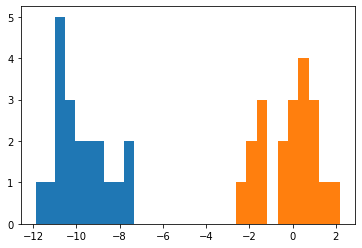

In [7]:
print("x0 shape: ", x0.shape)
print("x shape: ", xout.shape)

print("x0 mean: ", np.mean(x0))
print("x0 var: ", np.var(x0))

print("mean: ", np.mean(xout))
print("var: ", np.var(xout))

plt.hist(x0[:, 0])
plt.hist(xout[:, 0])

Now let's see what speedup `jit` gets us.

In [8]:
%timeit svgd(x, logp, stepsize, h, L, update_kernel_params=True, kernel_param_update_rule=kernel_param_update_rule)

1.08 s ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


* With jitted `update`: 12.2 ms per loop
* Without jitted `update`: 1.08 s per loop

So that's a speedup of around 100x. Sweet!

### Experiment 1.2
Target distribution:
$$ p(x) = 1/3 \mathcal N(-2, 1) + 2/3 \mathcal N(2, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(-10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.